In [87]:
from typing import List, Dict
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt


sns.set(rc={'figure.figsize':(20,14)})
sns.set(font_scale=6)

In [2]:
def fancy_name(benchmark_name: str) -> str:
    fancy_name: str = benchmark_name.split(".")[-2]\
        .replace("_shuffled", "")\
        .replace("_LTO", "")\
        .replace("tpch_", "")\
        .split("/")[-1]
    removed_numbers = fancy_name[:fancy_name.rindex("_")]
    return removed_numbers

def filter_unneccessary_benchmarks(data: DataFrame) -> DataFrame:
    filtered: DataFrame = data[~data["benchmark_run_name"].str.match(".*(LZ4|RunLength).*")]
    return filtered

def get_clients(run_name: str) -> int:
    if "shuffled" in run_name:
        clients_number: str = run_name.split(".")[-2].replace("_shuffled", "").split("_")[-1]
        return int(clients_number)
    return 1

def complete_info(data: DataFrame) -> DataFrame:
    new_data: DataFrame = data.copy()
    new_data["fancy_name"] = [fancy_name(b) for b in new_data["benchmark_run_name"]]
    new_data["with_lto"] = ["LTO" in benchmark_run_name for benchmark_run_name in new_data["benchmark_run_name"]]
    new_data["clients"] = [get_clients(run_name)
                           for run_name in new_data["benchmark_run_name"]]
    new_data["multithreaded"] = ["shuffled" in benchmark_run_name for benchmark_run_name in new_data["benchmark_run_name"]]
    return new_data

def complete_with_sizes(data: DataFrame, sizes_folder: Path) -> DataFrame:
    all_sizes: DataFrame = DataFrame()
    for library in data["fancy_name"].drop_duplicates():
        sizes: DataFrame = load_sizes(sizes_folder / f"sizes_{library}.txt")
        grouped_by_datatype = sizes.groupby("column_data_type")["size_in_bytes"].sum()
        grouped_by_datatype = grouped_by_datatype.T
        grouped_by_datatype["fancy_name"] = library
        all_sizes = all_sizes.append(grouped_by_datatype)
    completed_with_size = data.merge(all_sizes, on="fancy_name", how="left")
    return completed_with_size

def get_high_level(data_folder: Path, sizes_folder: Path) -> DataFrame:
    high_level: DataFrame = pd.read_csv(f"{data_folder}/benchmarks_parsed_high_level.csv")
    high_level = high_level.sort_values("benchmark_run_name")
    high_level = filter_unneccessary_benchmarks(high_level)
    high_level = complete_info(high_level)
    high_level = complete_with_sizes(high_level, sizes_folder)
    return high_level

def get_low_level(data_folder: Path) -> DataFrame:
    low_level: DataFrame = pd.read_csv(f"{data_folder}/benchmarks_parsed_low_level.csv")
    low_level = low_level.sort_values("query_name")
    low_level = filter_unneccessary_benchmarks(low_level)
    low_level = complete_info(low_level)
    return low_level

def load_sizes(sizes_file: Path) -> DataFrame:
    all_entries: List[List[str]] = []
    av_dict_entries: List[List[int]] = []
    column_names: List[str] = []
    types: List[str] = []
    with sizes_file.open() as file:
        table_starts: bool = False
        for line in file:
            if len(column_names) != 0 and table_starts and not '|' in line:
                break
            if not '|' in line:
                continue
            if len(column_names) == 0:
                column_names = [entry.replace(" ", "")
                                for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if len(types) == 0:
                types =  [entry.replace(" ", "")
                          for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if "<ValueS>" in line:
                table_starts = True
                continue
            if not table_starts:
                continue
            new_entry: List[str] = [entry.replace(" ", "")
                                    for entry in line.split("|") if entry != "" and entry != "\n"]
            all_entries.append(new_entry)
    as_type: Dict[str, str] = {column_names[i]:types[i] for i in range(0, len(column_names))}
    df = DataFrame(data=all_entries, columns=column_names).astype(as_type)
    return df

single_threaded_folder = Path("../data/segmentencoding20210227/")
multi_threaded_folder: Path = Path("../data/segmentencoding20210226/")
sizes_folder: Path = Path("../data/segmentencoding20210227/")
high_level_mult: DataFrame = get_high_level(multi_threaded_folder, sizes_folder)
low_level_mult: DataFrame = get_low_level(multi_threaded_folder)
high_level_single: DataFrame = get_high_level(single_threaded_folder, sizes_folder)
low_level_single: DataFrame = get_low_level(single_threaded_folder)
high_level_single

,benchmark_run_name,total_runtime,avg_throughput,fancy_name,with_lto,clients,multithreaded,float,int,string
0,./tpch_Dictionary_singlethreaded.json,1.248789e+08,20.315651,Dictionary,False,1,False,67553787.0,109498396.0,787538899.0
1,./tpch_FrameOfReference_singlethreaded.json,1.181196e+08,21.033784,FrameOfReference,False,1,False,67553787.0,85562152.0,787538899.0
2,./tpch_SIMDCAI_singlethreaded.json,1.239289e+08,19.207277,SIMDCAI,False,1,False,67553787.0,56486271.0,787538899.0
3,./tpch_TurboPFOR_bitpacking_singlethreaded.json,1.165187e+08,20.213111,TurboPFOR_bitpacking,False,1,False,67553787.0,56982948.0,787538899.0
4,./tpch_TurboPFOR_singlethreaded.json,1.233997e+08,19.258085,TurboPFOR,False,1,False,67553787.0,56637286.0,787538899.0
5,./tpch_Unencoded_singlethreaded.json,1.115322e+08,23.917376,Unencoded,False,1,False,67553787.0,128084188.0,787538899.0


## Runtime

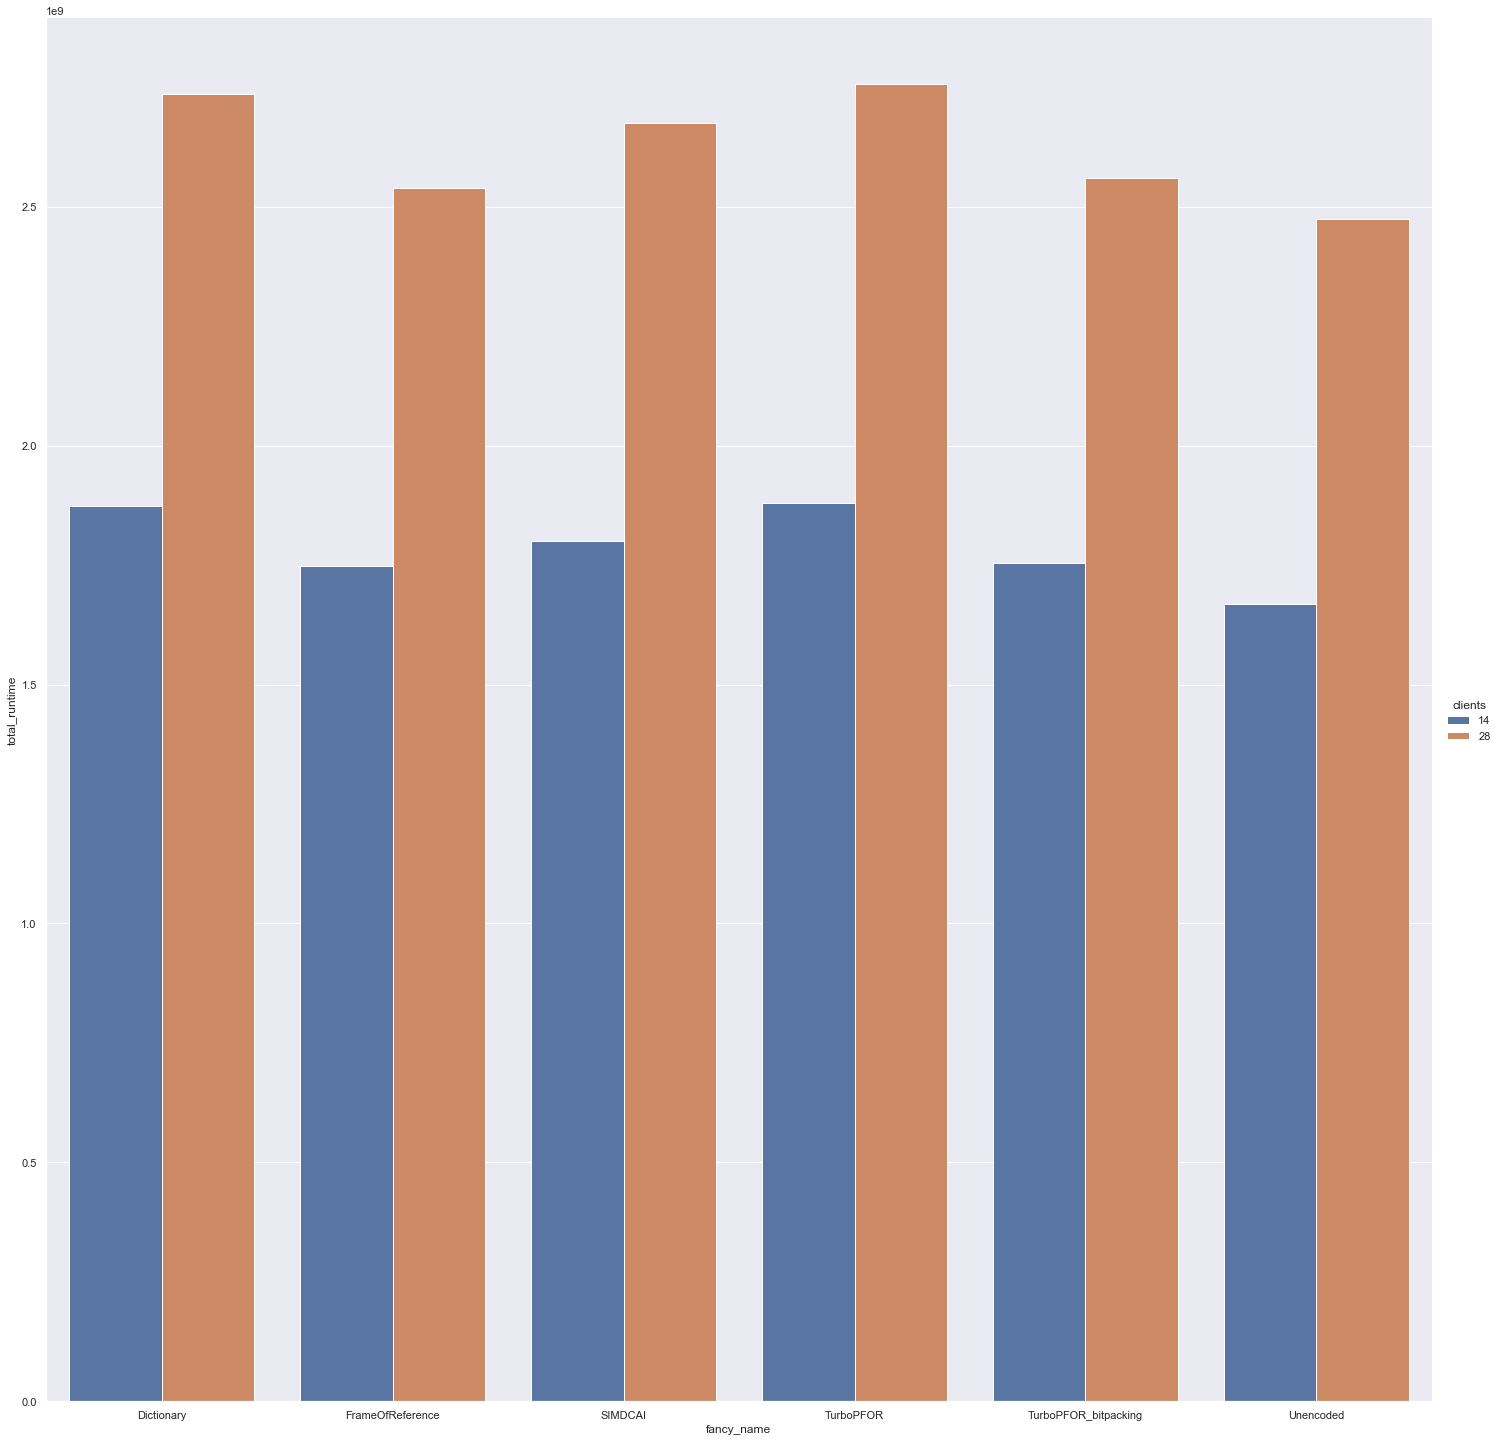

In [3]:
sns.catplot(data=high_level_mult, kind="bar", x="fancy_name", y="total_runtime", hue="clients", height=20)

In [52]:
def get_with_baseline(data: DataFrame) -> DataFrame:
    baseline_runtime: float = list(data[data["fancy_name"] == "Dictionary"]["total_runtime"])[0]
    baseline_integer: int =  list(data[data["fancy_name"] == "Dictionary"]["int"])[0]
    data["runtime_compared_to_baseline"] = [runtime / baseline_runtime for runtime in only_28_clients["total_runtime"]]
    data["size_compared_to_baseline"] = [int_size / baseline_integer for int_size in only_28_clients["int"]]
    data["runtime_in_ms"] = [runtime / 1000000 for runtime in only_28_clients["total_runtime"]]
    return data

only_28_clients: DataFrame = high_level_mult[high_level_mult["clients"] == 28 ]
get_with_baseline(only_28_clients)

<ipython-input-52-c31cf898747c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["runtime_compared_to_baseline"] = [runtime / baseline_runtime for runtime in only_28_clients["total_runtime"]]
<ipython-input-52-c31cf898747c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["size_compared_to_baseline"] = [int_size / baseline_integer for int_size in only_28_clients["int"]]
<ipython-input-52-c31cf898747c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,benchmark_run_name,total_runtime,avg_throughput,fancy_name,with_lto,clients,multithreaded,float,int,string,runtime_compared_to_baseline,size_compared_to_baseline,runtime_in_ms
1,./tpch_Dictionary_28_shuffled.json,2.736624e+09,0.460573,Dictionary,False,28,True,67553787.0,109498396.0,787538899.0,1.000000,1.000000,2736.623695
3,./tpch_FrameOfReference_28_shuffled.json,2.539802e+09,0.490804,FrameOfReference,False,28,True,67553787.0,85562152.0,787538899.0,0.928079,0.781401,2539.801972
5,./tpch_SIMDCAI_28_shuffled.json,2.675399e+09,0.465884,SIMDCAI,False,28,True,67553787.0,56486271.0,787538899.0,0.977628,0.515864,2675.398697
7,./tpch_TurboPFOR_28_shuffled.json,2.757843e+09,0.452128,TurboPFOR,False,28,True,67553787.0,56637286.0,787538899.0,1.007754,0.517243,2757.843193
9,./tpch_TurboPFOR_bitpacking_28_shuffled.json,2.560256e+09,0.486986,TurboPFOR_bitpacking,False,28,True,67553787.0,56982948.0,787538899.0,0.935553,0.520400,2560.256444
11,./tpch_Unencoded_28_shuffled.json,2.474695e+09,0.503728,Unencoded,False,28,True,67553787.0,128084188.0,787538899.0,0.904288,1.169736,2474.695129


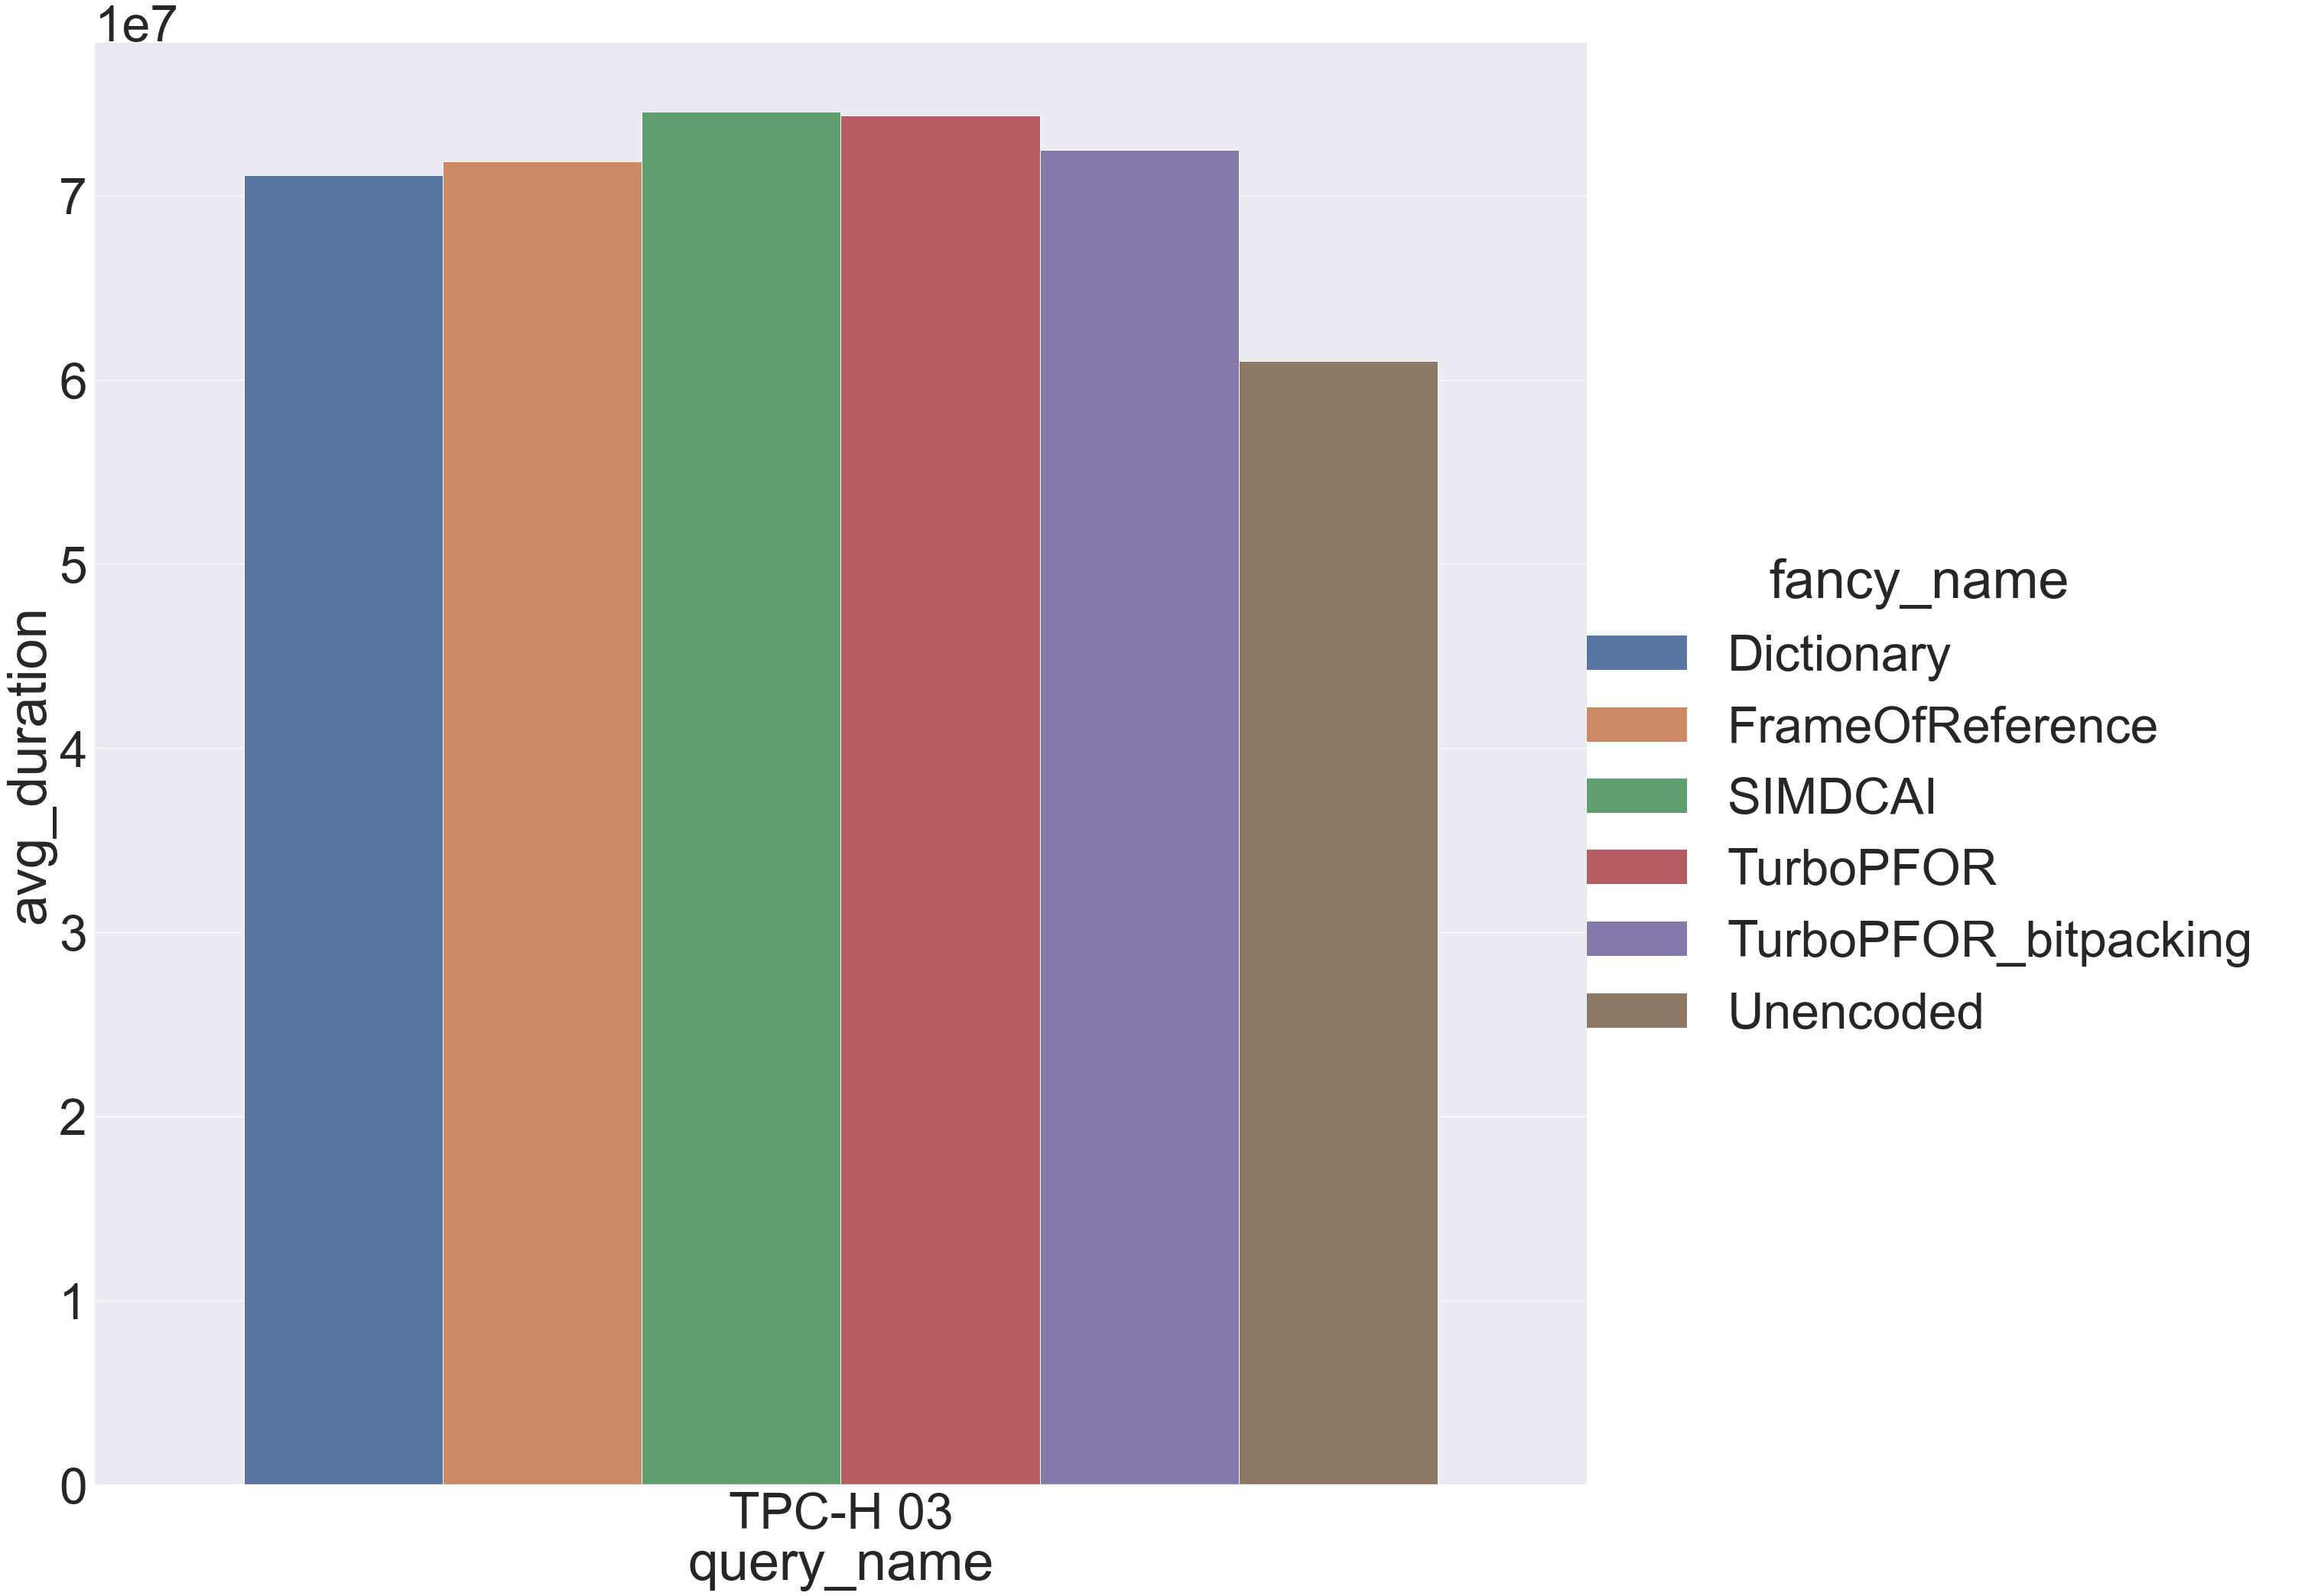

In [88]:
order: List[str] = sorted(low_level_single["fancy_name"].drop_duplicates())
filtered: DataFrame = low_level_single[low_level_single["query_name"] == "TPC-H 03"]
sns.catplot(data=filtered, x="query_name", y="avg_duration", kind="bar", hue="fancy_name", height=30, hue_order=order)
plt.savefig("visualizations/tpch03single.png")

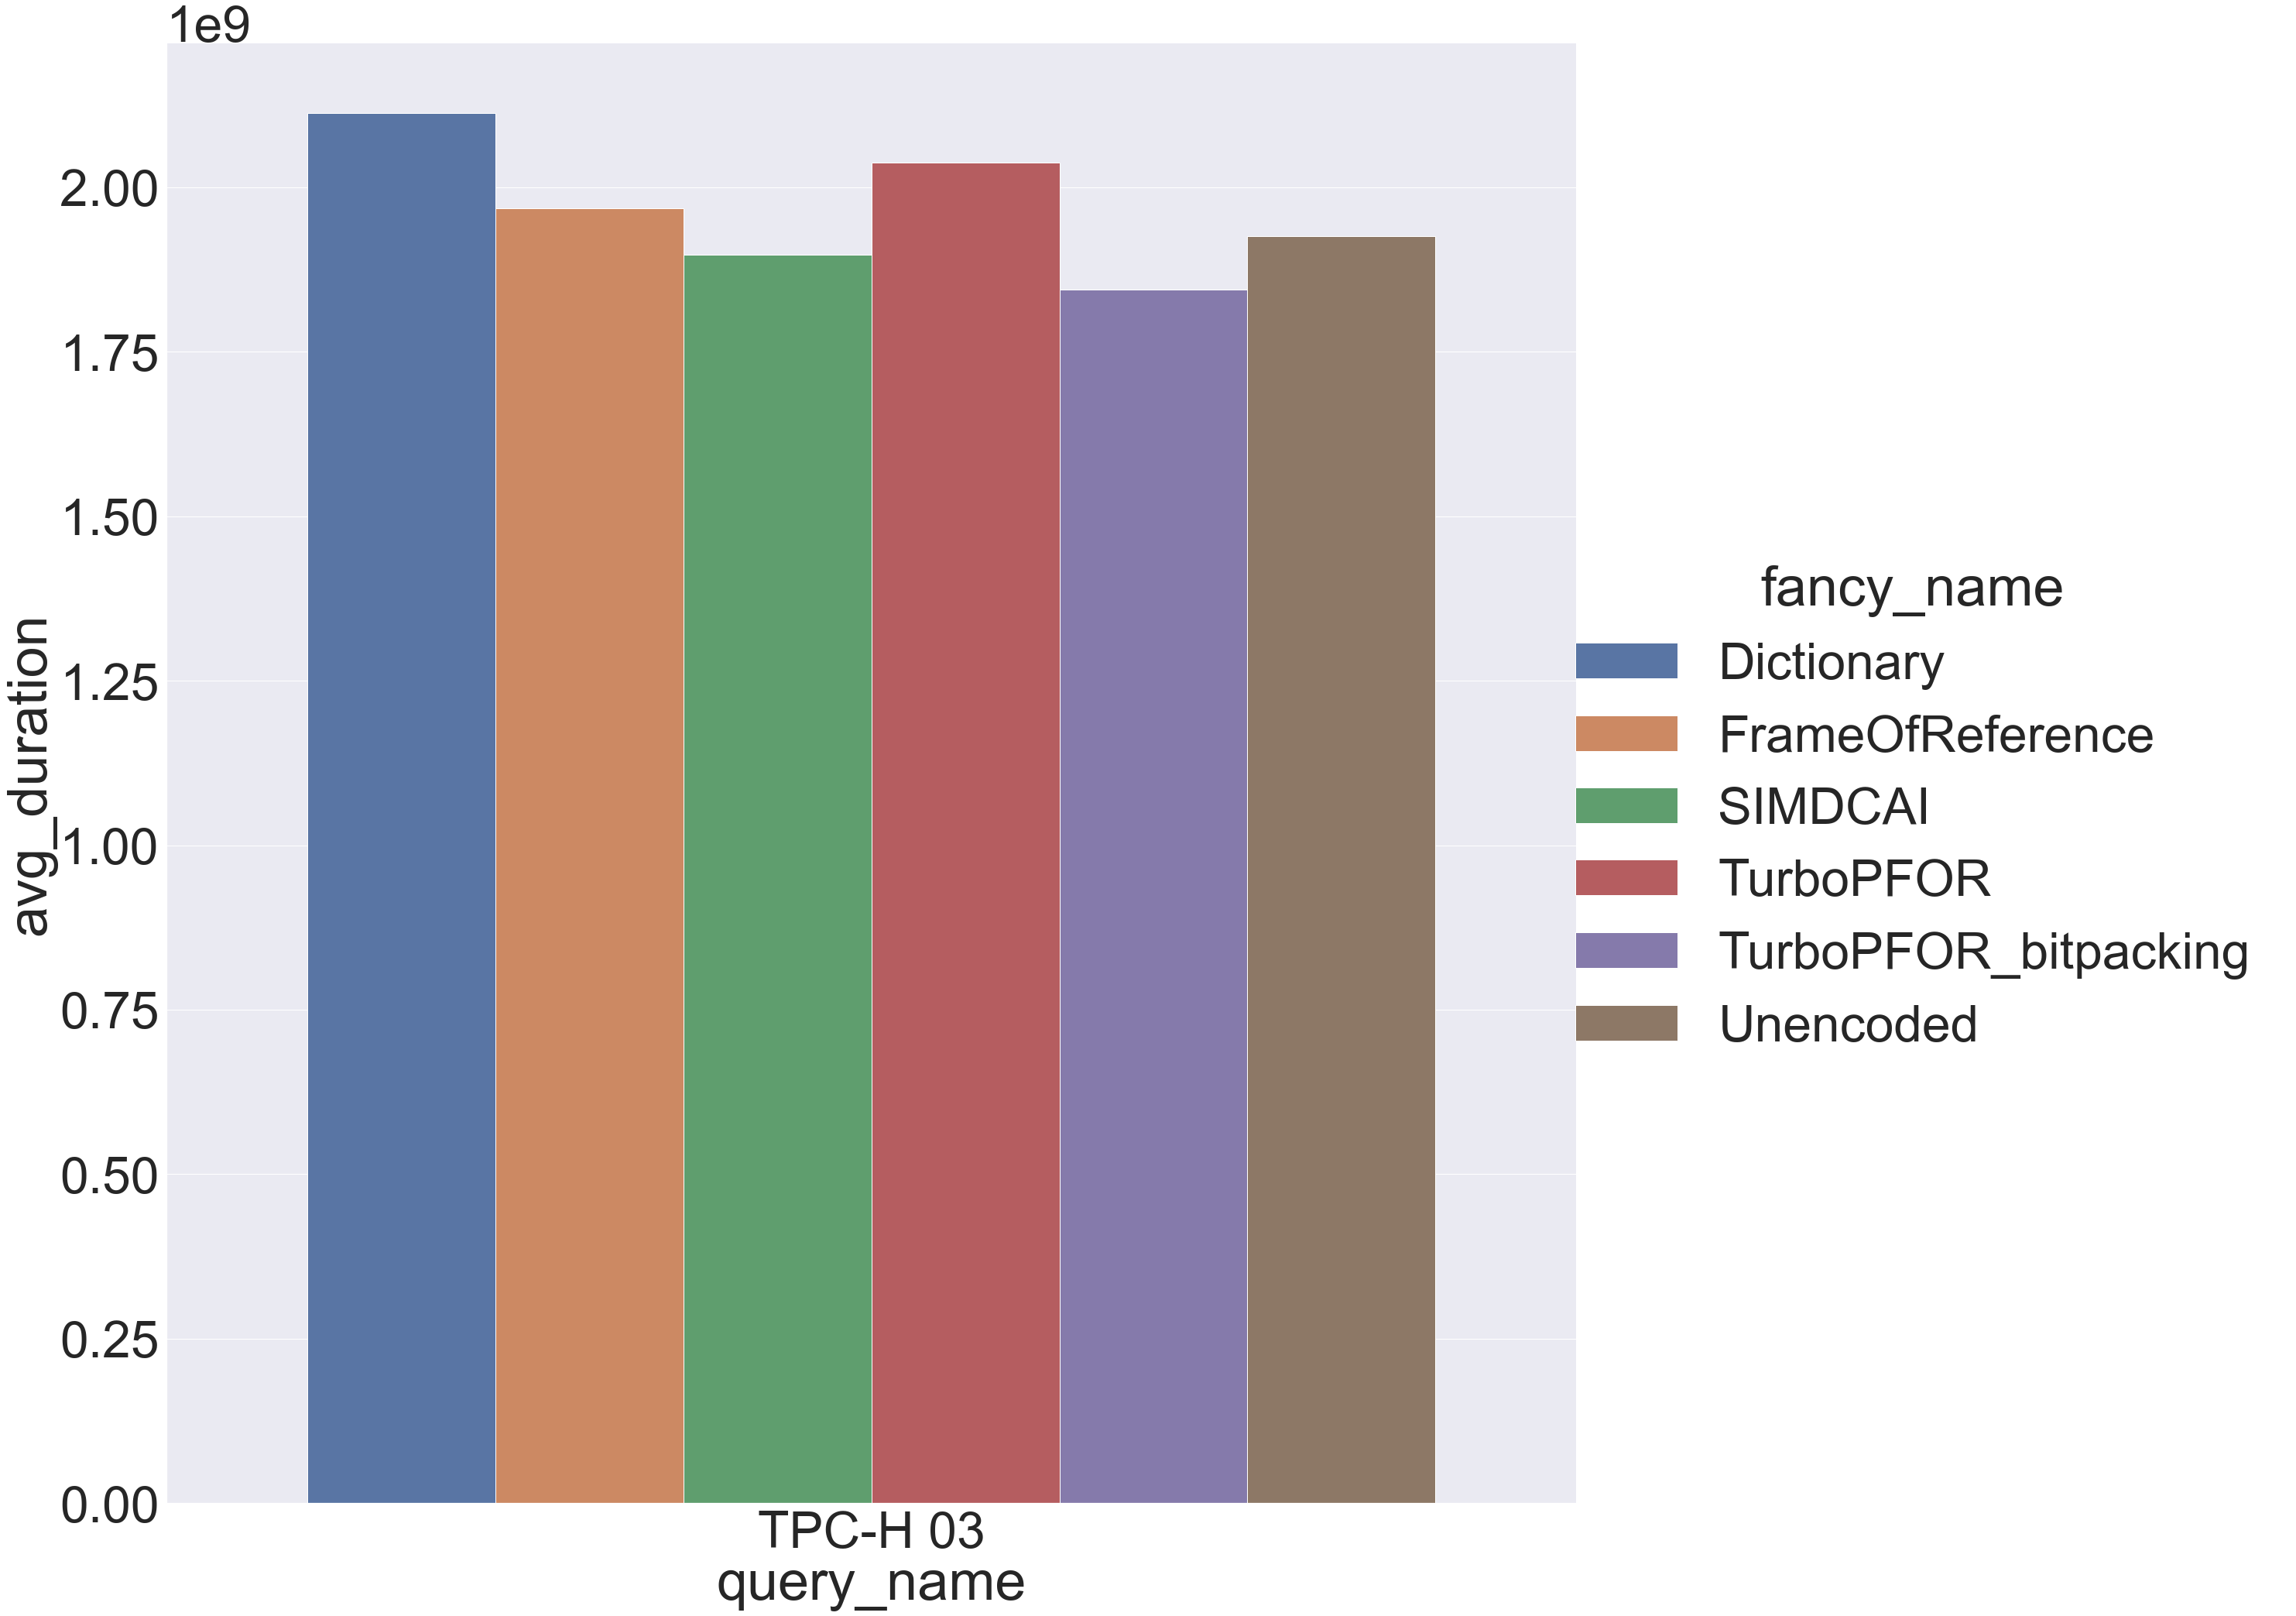

In [89]:
only_28_clients: DataFrame = low_level_mult[low_level_mult["clients"] == 28]
filtered: DataFrame = only_28_clients[only_28_clients["query_name"] == "TPC-H 03"]
plot = sns.catplot(data=filtered, x="query_name", y="avg_duration", kind="bar", hue="fancy_name", height=30, hue_order=order)
plt.savefig("visualizations/tpch03multi.png")

<AxesSubplot:xlabel='fancy_name', ylabel='reduction'>

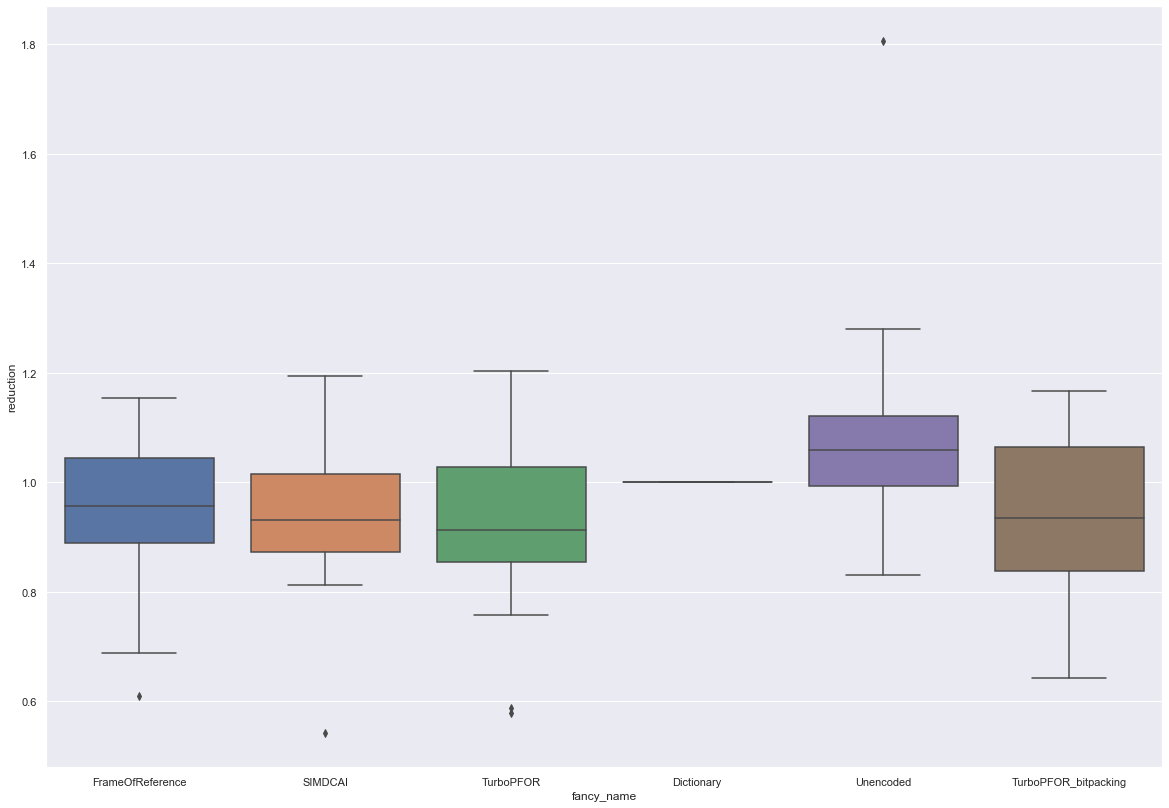

In [46]:
# Relative Difference
def with_relative_duration(data: DataFrame) -> DataFrame:
    dictionary_results: DataFrame = data[data["fancy_name"] == "Dictionary"]
    columns_to_merge: List[str] = ["query_name", "avg_duration"]
    with_baseline: DataFrame = data.merge(dictionary_results[columns_to_merge], on=["query_name"])
    with_baseline["duration_to_baseline"] = [encoded / baseline
                                             for encoded, baseline
                                             in zip(with_baseline["avg_duration_x"], with_baseline["avg_duration_y"])]
    return with_baseline

single_threaded: DataFrame = with_relative_duration(low_level_single)
multi_threaded: DataFrame = with_relative_duration(low_level_mult[low_level_mult["clients"] == 28])
columns_to_merge: List[str] = ["query_name", "fancy_name", "duration_to_baseline"]
combined: DataFrame = single_threaded.merge(multi_threaded[columns_to_merge], on=["fancy_name", "query_name"])
combined["reduction"] = [multi / single for single, multi
                         in zip(combined["duration_to_baseline_x"],
                                combined["duration_to_baseline_y"])]
sns.boxplot(data=combined, x="fancy_name", y="reduction")

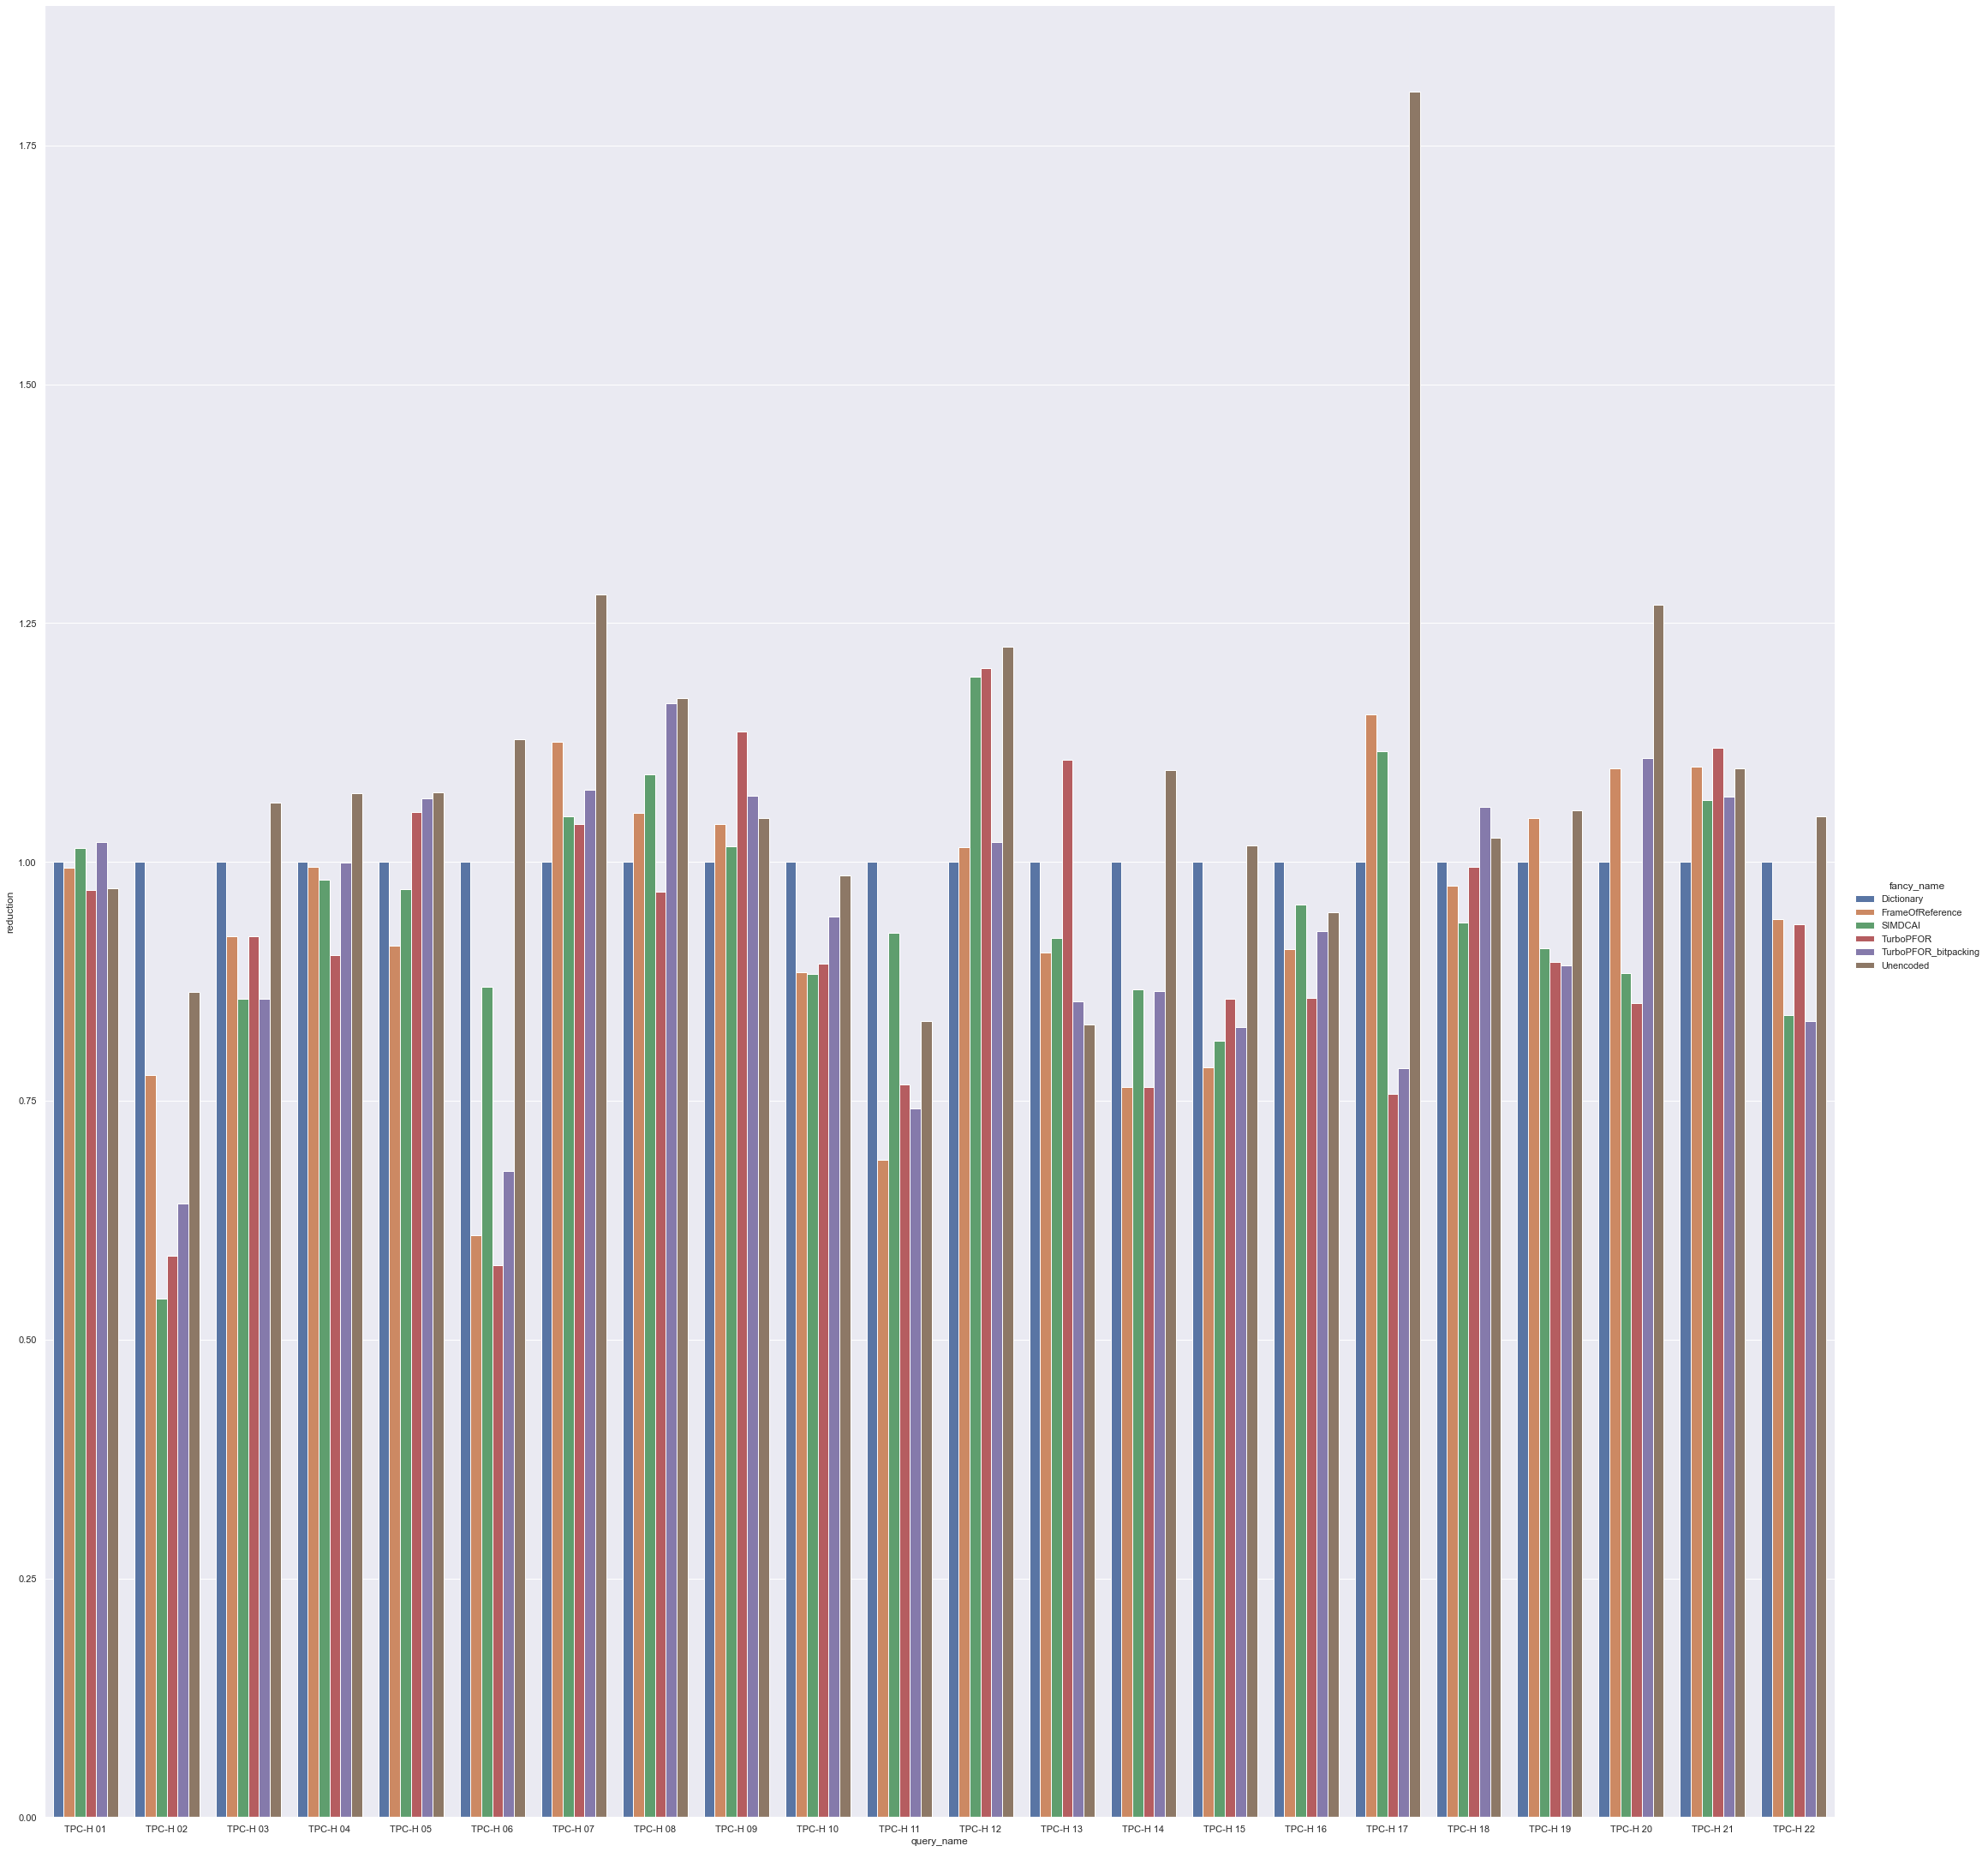

In [47]:
sns.catplot(data=combined, x="query_name", y="reduction", hue="fancy_name", kind="bar", height=30, hue_order=order)

In [71]:
integer_compressed: DataFrame = load_sizes(sizes_folder / "sizes_TurboPFOR_bitpacking.txt")
dictionary: DataFrame = load_sizes(sizes_folder / "sizes_Dictionary.txt")
columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", "size_in_bytes"]
merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"])
merged

,table_name,chunk_id,column_id,column_name,column_data_type,distinct_value_count,encoding_type,vector_compression_type,size_in_bytes_x,point_accesses,sequential_accesses,monotonic_accesses,random_accesses,dictionary_accesses,size_in_bytes_y
0,nation,0,0,n_nationkey,int,25,TurboPFOR,NULL,217,16791,119200,154080,10768,0,221
1,nation,0,1,n_name,string,25,Dictionary,FixedSize1ByteAligned,1153,0,487100,0,150901996,60204384,1153
2,nation,0,2,n_regionkey,int,5,TurboPFOR,NULL,211,0,520775,0,0,0,141
3,nation,0,3,n_comment,string,25,Dictionary,FixedSize1ByteAligned,3035,0,25,0,0,25,3035
4,part,0,0,p_partkey,int,65535,TurboPFOR,NULL,131271,0,224195235,26583817,9895735,0,393306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,customer,2,6,c_mktsegment,string,5,Dictionary,FixedSize1ByteAligned,19258,0,15692970,0,0,23070,19258
1814,customer,2,7,c_comment,string,18930,Dictionary,FixedSize2ByteAligned,2187310,0,18930,0,2964559,18930,2187310
1815,region,0,0,r_regionkey,int,5,TurboPFOR,NULL,203,20828,15,0,0,0,121
1816,region,0,1,r_name,string,5,Dictionary,FixedSize1ByteAligned,333,0,104145,0,0,104145,333


In [72]:
# Get DB Columns where Int Compression Had the most impact
sizes_per_column = merged.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes_x", "size_in_bytes_y"].sum()
sizes_per_column["compression"] = [x / y
                                     for x, y in zip(sizes_per_column["size_in_bytes_x"],
                                                     sizes_per_column["size_in_bytes_y"])]
only_int_columns = sizes_per_column[sizes_per_column["column_data_type"] == "int"]
only_int_columns

<ipython-input-72-7e87dc79139c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sizes_per_column = merged.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes_x", "size_in_bytes_y"].sum()


,table_name,column_name,column_data_type,size_in_bytes_x,size_in_bytes_y,compression
3,customer,c_custkey,int,313528,900288,0.348253
6,customer,c_nationkey,int,94355,150588,0.626577
12,lineitem,l_linenumber,int,2268982,6012623,0.377370
14,lineitem,l_orderkey,int,17272065,28357682,0.609079
15,lineitem,l_partkey,int,13521249,32488494,0.416186
22,lineitem,l_suppkey,int,10520687,15685266,0.670737
26,nation,n_nationkey,int,217,221,0.981900
27,nation,n_regionkey,int,211,141,1.496454
30,orders,o_custkey,int,3379629,7294040,0.463341
32,orders,o_orderkey,int,4317143,9002208,0.479565
